In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.data import load
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress
import torch
from torchvision import datasets, transforms, models
import torchvision.transforms as T
import argparse
from models.utils.joiner2 import Joiner
from models.utils.new_losses import *
from models.utils.metrics import Accuracy, Curating_Of_Attention_Loss
#from models.utils.dataLoader import *
from models.utils.datasets import CustomCifar
from models.utils.datasets import *
import webdataset as wds
from webdataset.dataset import Composable, IterableDataset, Shorthands
from itertools import islice

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
H = 32
W= 32
bs = 5
grid_l = 2
nclass = 10
backbone = False
epochs = 5

beta = 0.0005
gamma = 0.0005
sigma = 1.0

seed = 1234

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
transform = T.Compose([
T.Resize((H,W)),
T.ToTensor()#,
#T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transform = T.Compose([
T.Resize((H,W)),
T.ToTensor()#,
#T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def identity(x):
    return x

def void(x):
    return None

In [5]:
def my_sample_decoder(sample):
    result = dict(__key__=sample["__key__"])
    for key, value in sample.items():
            result[key] = value
    return result

def train_len():
    return 50000

In [6]:
url  = "data/WebDataset-GramCifar/train/GramCifar-{0..4}.tar"
valid = "data/WebDataset-GramCifar/valid/GramCifar-0.tar"


train = (
    wds.WebDataset(url)
    .shuffle(100)
    .decode("pil")
    .map(my_sample_decoder)
    #.map_dict(transform, identity)
    .to_tuple("input.pyd", "output.pyd")
    .map_tuple( transform, identity)
    #.length(train_len)
)

valid = (
    wds.WebDataset(valid)
    .shuffle(100)
    .decode("pil")
    .map(my_sample_decoder)
    #.map_dict(transform, identity)
    .to_tuple("input.pyd", "output.pyd")
    .map_tuple(valid_transform, identity)
)


#map(f): apply f to each sample
#map_dict(key=f, ...): apply f to its corresponding key
#map_tuple(f, g, ...): apply f, g, etc. to their corresponding values in the tuple

#for image, data in islice(dataset, 0, 3):
#    print(image.shape, image.dtype, type(data))

In [7]:
repr(next(iter(train)))[:200]

'(tensor([[[0.5569, 0.6745, 0.6902,  ..., 0.8471, 0.7765, 0.8039],\n         [0.7490, 0.7686, 0.6824,  ..., 0.8980, 0.8706, 0.8510],\n         [0.8627, 0.8510, 0.7529,  ..., 0.8784, 0.8824, 0.8549],\n    '

In [8]:
repr(next(iter(valid)))[:200]
#for image, data, label in islice(dataset, 0, 3):
#    print(data)

'(tensor([[[0.4196, 0.2627, 0.1020,  ..., 0.3490, 0.2824, 0.2863],\n         [0.4196, 0.2471, 0.1098,  ..., 0.3647, 0.3176, 0.3569],\n         [0.4157, 0.2627, 0.1647,  ..., 0.3451, 0.3294, 0.3647],\n    '

In [9]:
train.length = 50000
valid.length = 10000

In [10]:
train_dl = load.DataLoader(train,batch_size=5)
valid_dl = load.DataLoader(valid,batch_size=5)
dld = ImageDataLoaders(train_dl, valid_dl, device='cuda')

In [11]:
critic_loss = CriticLoss(beta=0.000005, sigma=1)

In [12]:
model = Joiner(num_encoder_layers = 6, nhead=8, backbone = backbone, num_classes = nclass, bypass=False, hidden_dim=256, 
batch_size=bs, image_h=H, image_w=W, grid_l=grid_l,penalty_factor="2")

In [13]:
#train_loader = torch.utils.data.DataLoader(dataset, batch_size=100, num_workers=8)

In [14]:
learner = Learner(dld, model, loss_func=critic_loss, metrics=[Accuracy,Curating_Of_Attention_Loss])

SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=3.0199516913853586e-05)

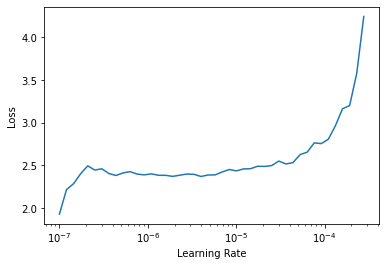

In [15]:
learner.lr_find()

In [21]:
learner.fit(1, 2e-7)

epoch,train_loss,valid_loss,Accuracy,time


KeyboardInterrupt: 

In [12]:
i=0
for inputs, labels in train_loader:
    print(i)
    i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [13]:
for inputs, labels in train_loader:
    print(inputs.shape)
    print(labels[0].shape)
    print(labels[1].shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 32, 32, 32])
torch.Size([100])
